In [36]:
import numpy as np
from pydantic import BaseModel, Field, model_validator
from typing import List, Dict, Tuple, Literal

import matplotlib.pyplot as plt
import numpy as np


class HamiltonianConstraint(BaseModel):
    """
        Represents an Hamiltonian term that imposes a constraint on the simulation
    """
    pass



class Hamiltonian(BaseModel):
    terms: Dict[str, HamiltonianConstraint]

class AdhesionConstraint(HamiltonianConstraint):
    """
        Pixels of the same cell will be constrained to stick together
    """

    def compute(self, source, target, simulation_state: "CPMSimulation"):
        """
            Compute the adhesion energy between the source and target pixels.
            Adhesion energy is high between similar cell types and low between different types.
        """
        # TODO

        return adhesion_energy

    def delta(self, source, target, simulation_state: "CPMSimulation"):
        """
            Calculates the change in Hamiltonian adhesion energy (ΔH) for the target pixel 
            if the source pixel value were copied there.
        """
        # Initial adhesion energy at the target
        initial_energy = self.compute(source, target, simulation_state)

        # Simulate the copy operation (source -> target) to calculate potential new energy
        target_value = simulation_state.grid[target[0], target[1], 0]
        simulation_state.grid[target[0], target[1], 0] = simulation_state.grid[source[0], source[1], 0]
        new_energy = self.compute(source, target, simulation_state)

        # Reset the target pixel to its original state
        simulation_state.grid[target[0], target[1], 0] = target_value

        return new_energy - initial_energy



class CPMSimulation(BaseModel):
    """
        Represents a lattice in which the cells live.

        It has multiple z dimensions (or layers):
        0: Cell ID
        1: Cell Type ID
        2: Subcellular Entities (e.g. 0 is Nothing, 1 is Cytoplasm, 2 is the Nucleus)
    """
    grid_size: int
    grid: np.ndarray
    dimensions: int = 3
    temperature: float = Field(1.0, description="Temperature for the simulation. The higher the temperature, the more energetically unfavourable copy attempts will succeed.")
    neighborhood: Literal["moore"] = Field("moore", description="Which kind of neighborhood to check.")
    strength: np.ndarray = Field(1, description="Strength of the adhesion")
    constraints: List[HamiltonianConstraint] = Field([AdhesionConstraint()])

    class Config:
        arbitrary_types_allowed = True

    def spawn_random_cell(self, n: int):
        """
            Spawn `n` random cells in the grid, assigning unique cell IDs.
            
            Parameters
            ----------
            n : int
                The number of cells to spawn.
        """
        # TODO: Consider placing the cytoplasm initially
        # Iterate over each cell to be spawned
        for cell_id in range(1, n + 1):  # Start cell IDs from 1 since 0 is the background
            # Randomly select a position in the grid until an empty one is found
            while True:
                x, y = np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)
                if self.grid[x, y, 0] == 0:  # Check if the cell ID layer at (x, y) is empty (background)
                    # Place the new cell
                    self.grid[x, y, 0] = cell_id  # Set cell ID
                    self.grid[x, y, 1] = 1 
                    break  # Exit the loop once the cell is placed

    @model_validator(mode='before')
    def initialize_lattice(cls, values):
        grid_size = values.get("grid_size", 64)
        dimensions = values.get("dimensions", 3)
        if "grid" not in values:
            values["grid"] = np.zeros((grid_size, grid_size, dimensions))
        return values
    
    def get_random_pixel(self) -> Tuple[Tuple[int, int], np.ndarray]:
        """
            Returns a random grid pixel.

            Returns
            -------
            coords: Tuple[int, int] - The coordinates of the sampled pixel
            value: np.ndarray - the slice of the grid corresponding to coords
        """
        x = np.random.randint(0, self.grid_size)
        y = np.random.randint(0, self.grid_size)
        return (x, y), self.grid[x, y]

    def _moore_neighborhood(self, x: int, y: int) -> List[Tuple[int, int]]:
            """
                Generates the Moore neighborhood (8 neighbors) for a given pixel at (x, y).
                Ensures neighbors are within grid bounds.

                Parameters
                ----------
                x, y: int - Coordinates of the source pixel

                Returns
                -------
                neighbors: List[Tuple[int, int]] - List of coordinates for the Moore neighborhood
            """
            neighbors = []
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue  # Skip the source pixel itself
                    nx, ny = x + dx, y + dy
                    # Check boundaries to avoid edge errors
                    if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                        neighbors.append((nx, ny))
            return neighbors

    def get_random_neighbour(self, source_coords: Tuple[int, int], neighborhood="moore") -> Tuple[Tuple[int, int], np.ndarray]:
        """
            Returns a random neighbor of the source pixel based on the specified neighborhood.

            Parameters
            ----------
            source_coords: Tuple[int, int] - Coordinates of the source pixel
            neighborhood: str - The type of neighborhood ("moore" for 8 neighbors)

            Returns
            -------
            neighbor_coords: Tuple[int, int] - Coordinates of the randomly chosen neighbor
            neighbor_value: np.ndarray - The slice of the grid corresponding to the neighbor
        """
        x, y = source_coords
        if neighborhood == "moore":
            neighbors = self._moore_neighborhood(x, y)
        else:
            raise NotImplementedError("Unsupported neighborhood type. Only 'moore' is implemented.")
        
        if not neighbors:
            raise ValueError("No neighbors found, check lattice boundaries or neighborhood size.")
        
        # Pick a random neighbor
        neighbor_coords = neighbors[np.random.randint(len(neighbors))]
        return neighbor_coords, self.grid[neighbor_coords[0], neighbor_coords[1]]

    def get_pixel(self, coords: List[int]):
        return self.grid[coords, :]

    def copy_pixel(self, source, target):
        """
            Copy a pixel (and their other dimensions) from source coordinates to target coordinates.
        """
        self.grid[target, :] = self.grid[source, :]

    def render(self):
        """
            Renders the current state of the simulation grid.
            Each cell ID will be represented by a different color.
        """
        # Extract the cell ID layer (first layer) for rendering
        cell_id_layer = self.grid[:, :, 0]

        # Define a color map; 'n' colors based on unique cell IDs
        unique_ids = np.unique(cell_id_layer)
        color_map = plt.cm.get_cmap("viridis", len(unique_ids))

        # Map each cell ID to a unique color index
        color_indices = np.searchsorted(unique_ids, cell_id_layer)

        # Plot the grid using the color indices
        plt.imshow(color_indices, cmap=color_map, origin="upper")
        plt.colorbar(label="Cell ID")
        plt.title("Cellular Potts Model Simulation")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

class CPM():
    def __init__(self, sim_config: CPMSimulation):
        self.sim = sim_config

    def metropolis(self):
        
        for n in range(self.sim.grid_size**2):

            # s_*: source t_*: target
            s_coord, (s_cell, s_type, s_sub) = self.sim.get_random_pixel()
            t_coord, (t_cell, t_type, t_sub) = self.sim.get_random_neighbour(source_coords=s_coord)

            if s_cell == t_cell:
                continue
            
            # Copy attempt
            # TODO: Compute Hamiltonian
            for h in self.sim.constraints
            delta_energy = 1
            
            # Attempt outcome
            if delta_energy <= 0 or np.random.uniform() <= np.exp(-delta_energy/self.sim.temperature):
                self.sim.copy_pixel(source=t_coord, target=t_coord)
        

    def step(self, n=1):
        """ Perform n steps of Cellular Pott Model"""
        for n in range(n):
            print(f"{n=}")
            self.metropolis()

    def _render_animation(self):
        """
            Displays a widget to play the full animation
        """
        pass


/var/folders/6k/bmxrc4yx7qvcz0jxn0qwv6v00000gp/T/ipykernel_38187/1016062366.py:166: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("viridis", len(unique_ids))


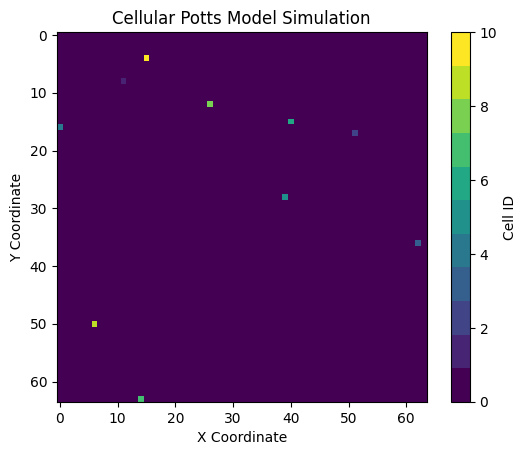

n=0


In [37]:

config = CPMSimulation(grid_size=64, temperature=1.0)
cpm = CPM(sim_config=config)
config.spawn_random_cell(10)
config.render()
cpm.step()

n=0


/var/folders/6k/bmxrc4yx7qvcz0jxn0qwv6v00000gp/T/ipykernel_38187/1016062366.py:166: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("viridis", len(unique_ids))


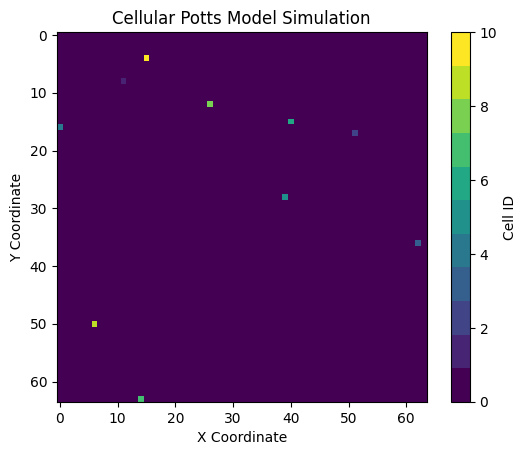

In [62]:
cpm.step()
config.render()